In [1]:
import numpy as np 
import pandas as pd
import timm
import shutil
import os
import random
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
device='cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

**Data split**

In [3]:
class_names = ['Pepper__bell', 'Potato', 'Tomato']
normalized_class_names = [re.sub(r'[^a-zA-Z0-9]', '', class_name).lower() for class_name in class_names]

root_directory = '/kaggle/input/plantdisease/PlantVillage'
directories = os.listdir(root_directory)


sub_dir = []


for dir in directories:
    dir_normalized = re.sub(r'[^a-zA-Z0-9]', '', dir).lower()

    for normalized_class_name in normalized_class_names:
        if normalized_class_name in dir_normalized:
            sub_dir.append(dir)

print("Identified subdirectories:", sub_dir)

Identified subdirectories: ['Pepper__bell___Bacterial_spot', 'Potato___healthy', 'Tomato_Leaf_Mold', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Bacterial_spot', 'Tomato_Septoria_leaf_spot', 'Tomato_healthy', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight', 'Tomato__Target_Spot', 'Pepper__bell___healthy', 'Potato___Late_blight', 'Tomato_Late_blight', 'Potato___Early_blight', 'Tomato__Tomato_mosaic_virus']


In [4]:
# Setting up source and destination folders for training and testing
source_folder = "/kaggle/working/"
train_folder = os.path.join(source_folder, "train")
test_folder = os.path.join(source_folder, "test")

split_ratio = 0.8

os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Process each identified subdirectory (class)
for subfolder in sub_dir:
    subfolder_path = os.path.join(root_directory, subfolder)
    

    images = os.listdir(subfolder_path)
    random.shuffle(images)
    
    # Split images into training and testing sets
    split_index = int(len(images) * split_ratio)
    train_images = images[:split_index]
    test_images = images[split_index:]
    
    # Create class-specific subfolders in the train and test folders
    os.makedirs(os.path.join(train_folder, subfolder), exist_ok=True)
    os.makedirs(os.path.join(test_folder, subfolder), exist_ok=True)
    

    for image in train_images:
        src = os.path.join(subfolder_path, image)
        dst = os.path.join(train_folder, subfolder, image)
        shutil.copy(src, dst) 


    for image in test_images:
        src = os.path.join(subfolder_path, image)
        dst = os.path.join(test_folder, subfolder, image)
        shutil.copy(src, dst)

print("Data split and copied to train and test folders.")

Data split and copied to train and test folders.


In [5]:
#Data transformation and Augmentation
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=45),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), 
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
    
])

# def custom_collate(batch):
  
#     transform = transforms.Compose([
#         transforms.Resize((224, 224))
       
#     ])
    
    
#     batch = [(transform(item[0]), item[1]) for item in batch]
    
   
#     return torch.utils.data.dataloader.default_collate(batch)

val_transforms = transforms.Compose([
    transforms.Resize(224),  
    transforms.ToTensor(),
])

train_dataset = ImageFolder(root=train_folder, transform=train_transforms)
val_dataset=ImageFolder(root=test_folder,transform=val_transforms)

In [6]:
train_dataset.classes

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32,collate_fn=custom_collate)

num_classes=len(train_dataset.classes)

**Model Building**

In [8]:
class CustomResNet50(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)


model_resnet50 = CustomResNet50(num_classes=num_classes).to(device)

for params in model_resnet50.parameters():
    params.requires_grad=False
for params in model_resnet50.resnet.fc.parameters():
    params.requires_grad=True

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]


In [9]:
class CustomVGG16(nn.Module):
    def __init__(self, num_classes=1):
        super(CustomVGG16, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)
        num_features = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.vgg16(x)

model_vgg16 = CustomVGG16(num_classes=num_classes).to(device)

for params in model_vgg16.parameters():
    params.requires_grad=False
for params in model_vgg16.vgg16.classifier[-1].parameters():
    params.requires_grad=True

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 160MB/s] 


In [10]:
class CustomVisionTransformer(nn.Module):
    def __init__(self, num_classes=1, model_name='vit_base_patch16_224'):
        super(CustomVisionTransformer, self).__init__()
        self.vit = timm.create_model(model_name, pretrained=True)
        num_features = self.vit.head.in_features
        self.vit.head = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.vit(x)


model_vit = CustomVisionTransformer(num_classes=num_classes, model_name='vit_base_patch16_224').to(device)

for params in model_vit.parameters():
    params.requires_grad=False
for params in model_vit.vit.head.parameters():
    params.requires_grad=True

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [11]:
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
class DinoVisionTransformerClassifier(nn.Module):
    def __init__(self,num_classes):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.transformer = dinov2_vitl14
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.transformer(x)
        x = self.transformer.norm(x)
        x = self.classifier(x)
        return x
    
model_dino=DinoVisionTransformerClassifier(num_classes).to(device)

for params in model_dino.parameters():
    params.requires_grad=False
for params in model_dino.classifier[-1].parameters():
    params.requires_grad=True

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth
100%|██████████| 1.13G/1.13G [00:04<00:00, 281MB/s] 


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Load the pretrained DINO Vision Transformer model
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((14, 14))
        self.channel_reducer = nn.Conv2d(256, 3, kernel_size=1, stride=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # First conv + pool layer
        x = self.pool(F.relu(self.conv2(x)))  # Second conv + pool layer
        x = self.pool(F.relu(self.conv3(x)))  # Third conv + pool layer

        x = self.global_avg_pool(x)  # Pool to (batch_size, 256, 14, 14)
    
        # Reduce channels from 256 to 3 to match ViT input expectations
        x = self.channel_reducer(x)
        
        return x


class HybridCNNViTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(HybridCNNViTClassifier, self).__init__()

        self.cnn = CustomCNN()
        self.transformer = dinov2_vitl14
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.cnn(x)
        x = self.transformer(x)  
        x = self.transformer.norm(x) 
        
        x = self.classifier(x)
        return x


model_hybrid = HybridCNNViTClassifier(num_classes=num_classes).to(device)


for params in model_hybrid.parameters():
    params.requires_grad = False
for params in model_hybrid.classifier.parameters():
    params.requires_grad = True


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
models = [model_resnet50, model_vgg16,  model_vit, model_dino, model_hybrid]
# models = [model_hybrid]
optimizers = [optim.Adam(model.parameters(), lr=0.001) for model in models]

criterion = nn.CrossEntropyLoss()


training_loss = [[] for _ in models]
validation_loss = [[] for _ in models]
training_accuracy = [[] for _ in models]
validation_accuracy = [[] for _ in models]
training_precisions=[[] for _ in models]
validation_precisions=[[] for _ in models]
training_recalls=[[] for _ in models]
validation_recalls=[[] for _ in models]
training_f1_scores=[[] for _ in models]
validation_f1_scores=[[] for _ in models]

In [15]:
img,label=next(iter(val_loader))

**Model training**

In [15]:

num_epochs = 25

for epoch in tqdm(range(num_epochs), total=num_epochs):
    for model, optimizer, train_losses, val_losses, train_acc, val_acc, train_precisions, val_precisions, train_recalls, val_recalls, train_f1_scores, val_f1_scores in zip(models, optimizers, training_loss, validation_loss, training_accuracy, validation_accuracy, training_precisions, validation_precisions, training_recalls, validation_recalls, training_f1_scores, validation_f1_scores):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        predictions = []
        true_labels = []

        for inputs, labels in (train_loader):
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

        train_losses.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        
        train_precision = precision_score(true_labels, predictions, average='weighted')
        train_rec = recall_score(true_labels, predictions, average='weighted')
        train_f1 = f1_score(true_labels, predictions, average='weighted')
        
        train_precisions.append(train_precision)
        train_recalls.append(train_rec)
        train_f1_scores.append(train_f1)

        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        predictions = []
        true_labels = []

        with torch.no_grad():
            for inputs, labels in (val_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        val_losses.append(running_loss / len(val_loader))
        val_acc.append(100 * correct / total)

        val_precision = precision_score(true_labels, predictions, average='weighted')
        val_rec = recall_score(true_labels, predictions, average='weighted')
        val_f1 = f1_score(true_labels, predictions, average='weighted')

        val_precisions.append(val_precision)
        val_recalls.append(val_rec)
        val_f1_scores.append(val_f1)
        
        print(f"Model: {type(model).__name__}, Epoch: {epoch + 1}")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_acc[-1]:.2f}%")
        print(f"Train Precision: {train_precision:.4f}, Train Recall: {train_rec:.4f}, Train F1 Score: {train_f1:.4f}")
        print(f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_acc[-1]:.2f}%")
        print(f"Validation Precision: {val_precision:.4f}, Validation Recall: {val_rec:.4f}, Validation F1 Score: {val_f1:.4f}")
        print('\n')

  0%|          | 0/25 [00:00<?, ?it/s]

Model: CustomResNet50, Epoch: 1
Train Loss: 1.3601, Train Accuracy: 57.80%
Train Precision: 0.5693, Train Recall: 0.5780, Train F1 Score: 0.5634
Validation Loss: 1.0404, Validation Accuracy: 64.67%
Validation Precision: 0.7739, Validation Recall: 0.6467, Validation F1 Score: 0.6305


Model: CustomVGG16, Epoch: 1
Train Loss: 1.7100, Train Accuracy: 44.77%
Train Precision: 0.4270, Train Recall: 0.4477, Train F1 Score: 0.4315
Validation Loss: 1.3400, Validation Accuracy: 53.21%
Validation Precision: 0.6869, Validation Recall: 0.5321, Validation F1 Score: 0.5069


Model: CustomVisionTransformer, Epoch: 1
Train Loss: 0.7422, Train Accuracy: 77.38%
Train Precision: 0.7715, Train Recall: 0.7738, Train F1 Score: 0.7709
Validation Loss: 0.2979, Validation Accuracy: 91.63%
Validation Precision: 0.9199, Validation Recall: 0.9163, Validation F1 Score: 0.9167




  4%|▍         | 1/25 [21:37<8:38:58, 1297.44s/it]

Model: DinoVisionTransformerClassifier, Epoch: 1
Train Loss: 1.4790, Train Accuracy: 57.53%
Train Precision: 0.5769, Train Recall: 0.5753, Train F1 Score: 0.5528
Validation Loss: 0.9410, Validation Accuracy: 76.63%
Validation Precision: 0.7928, Validation Recall: 0.7663, Validation F1 Score: 0.7479


Model: CustomResNet50, Epoch: 2
Train Loss: 1.0044, Train Accuracy: 67.59%
Train Precision: 0.6708, Train Recall: 0.6759, Train F1 Score: 0.6701
Validation Loss: 0.7486, Validation Accuracy: 75.20%
Validation Precision: 0.7930, Validation Recall: 0.7520, Validation F1 Score: 0.7519


Model: CustomVGG16, Epoch: 2
Train Loss: 1.5696, Train Accuracy: 48.92%
Train Precision: 0.4748, Train Recall: 0.4892, Train F1 Score: 0.4799
Validation Loss: 1.1488, Validation Accuracy: 60.63%
Validation Precision: 0.6916, Validation Recall: 0.6063, Validation F1 Score: 0.6085


Model: CustomVisionTransformer, Epoch: 2
Train Loss: 0.4049, Train Accuracy: 87.71%
Train Precision: 0.8763, Train Recall: 0.8771, 

  8%|▊         | 2/25 [43:14<8:17:17, 1297.30s/it]

Model: DinoVisionTransformerClassifier, Epoch: 2
Train Loss: 0.9567, Train Accuracy: 71.98%
Train Precision: 0.7155, Train Recall: 0.7198, Train F1 Score: 0.7114
Validation Loss: 0.7088, Validation Accuracy: 81.56%
Validation Precision: 0.8203, Validation Recall: 0.8156, Validation F1 Score: 0.8077


Model: CustomResNet50, Epoch: 3
Train Loss: 0.9367, Train Accuracy: 69.46%
Train Precision: 0.6908, Train Recall: 0.6946, Train F1 Score: 0.6909
Validation Loss: 0.7142, Validation Accuracy: 76.36%
Validation Precision: 0.8147, Validation Recall: 0.7636, Validation F1 Score: 0.7633


Model: CustomVGG16, Epoch: 3
Train Loss: 1.5400, Train Accuracy: 50.28%
Train Precision: 0.4893, Train Recall: 0.5028, Train F1 Score: 0.4943
Validation Loss: 1.0677, Validation Accuracy: 63.56%
Validation Precision: 0.7124, Validation Recall: 0.6356, Validation F1 Score: 0.6381


Model: CustomVisionTransformer, Epoch: 3
Train Loss: 0.3510, Train Accuracy: 88.78%
Train Precision: 0.8873, Train Recall: 0.8878, 

 12%|█▏        | 3/25 [1:04:45<7:54:33, 1294.25s/it]

Model: DinoVisionTransformerClassifier, Epoch: 3
Train Loss: 0.8269, Train Accuracy: 75.22%
Train Precision: 0.7493, Train Recall: 0.7522, Train F1 Score: 0.7476
Validation Loss: 0.6343, Validation Accuracy: 82.00%
Validation Precision: 0.8335, Validation Recall: 0.8200, Validation F1 Score: 0.8078


Model: CustomResNet50, Epoch: 4
Train Loss: 0.8842, Train Accuracy: 70.63%
Train Precision: 0.7028, Train Recall: 0.7063, Train F1 Score: 0.7033
Validation Loss: 0.5966, Validation Accuracy: 80.14%
Validation Precision: 0.8252, Validation Recall: 0.8014, Validation F1 Score: 0.8013


Model: CustomVGG16, Epoch: 4
Train Loss: 1.5404, Train Accuracy: 50.76%
Train Precision: 0.4943, Train Recall: 0.5076, Train F1 Score: 0.4992
Validation Loss: 1.0567, Validation Accuracy: 63.85%
Validation Precision: 0.7473, Validation Recall: 0.6385, Validation F1 Score: 0.6524


Model: CustomVisionTransformer, Epoch: 4
Train Loss: 0.3104, Train Accuracy: 90.22%
Train Precision: 0.9019, Train Recall: 0.9022, 

 16%|█▌        | 4/25 [1:26:17<7:32:38, 1293.27s/it]

Model: DinoVisionTransformerClassifier, Epoch: 4
Train Loss: 0.7601, Train Accuracy: 76.67%
Train Precision: 0.7639, Train Recall: 0.7667, Train F1 Score: 0.7628
Validation Loss: 0.5766, Validation Accuracy: 84.15%
Validation Precision: 0.8522, Validation Recall: 0.8415, Validation F1 Score: 0.8332


Model: CustomResNet50, Epoch: 5
Train Loss: 0.8673, Train Accuracy: 71.60%
Train Precision: 0.7121, Train Recall: 0.7160, Train F1 Score: 0.7129
Validation Loss: 0.5777, Validation Accuracy: 80.33%
Validation Precision: 0.8284, Validation Recall: 0.8033, Validation F1 Score: 0.8037


Model: CustomVGG16, Epoch: 5
Train Loss: 1.5360, Train Accuracy: 51.21%
Train Precision: 0.5006, Train Recall: 0.5121, Train F1 Score: 0.5048
Validation Loss: 1.0232, Validation Accuracy: 65.28%
Validation Precision: 0.7083, Validation Recall: 0.6528, Validation F1 Score: 0.6479


Model: CustomVisionTransformer, Epoch: 5
Train Loss: 0.2846, Train Accuracy: 90.77%
Train Precision: 0.9076, Train Recall: 0.9077, 

 20%|██        | 5/25 [1:47:44<7:10:25, 1291.30s/it]

Model: DinoVisionTransformerClassifier, Epoch: 5
Train Loss: 0.7266, Train Accuracy: 77.09%
Train Precision: 0.7693, Train Recall: 0.7709, Train F1 Score: 0.7682
Validation Loss: 0.5356, Validation Accuracy: 84.78%
Validation Precision: 0.8521, Validation Recall: 0.8478, Validation F1 Score: 0.8426


Model: CustomResNet50, Epoch: 6
Train Loss: 0.8437, Train Accuracy: 72.74%
Train Precision: 0.7250, Train Recall: 0.7274, Train F1 Score: 0.7254
Validation Loss: 0.6310, Validation Accuracy: 78.80%
Validation Precision: 0.8391, Validation Recall: 0.7880, Validation F1 Score: 0.7904


Model: CustomVGG16, Epoch: 6
Train Loss: 1.5307, Train Accuracy: 51.10%
Train Precision: 0.5002, Train Recall: 0.5110, Train F1 Score: 0.5043
Validation Loss: 1.0861, Validation Accuracy: 63.30%
Validation Precision: 0.7042, Validation Recall: 0.6330, Validation F1 Score: 0.6122


Model: CustomVisionTransformer, Epoch: 6
Train Loss: 0.2770, Train Accuracy: 91.11%
Train Precision: 0.9108, Train Recall: 0.9111, 

 24%|██▍       | 6/25 [2:09:19<6:49:18, 1292.55s/it]

Model: DinoVisionTransformerClassifier, Epoch: 6
Train Loss: 0.7076, Train Accuracy: 77.49%
Train Precision: 0.7728, Train Recall: 0.7749, Train F1 Score: 0.7720
Validation Loss: 0.5123, Validation Accuracy: 85.17%
Validation Precision: 0.8580, Validation Recall: 0.8517, Validation F1 Score: 0.8499


Model: CustomResNet50, Epoch: 7
Train Loss: 0.8236, Train Accuracy: 73.18%
Train Precision: 0.7295, Train Recall: 0.7318, Train F1 Score: 0.7299
Validation Loss: 0.6649, Validation Accuracy: 77.35%
Validation Precision: 0.8334, Validation Recall: 0.7735, Validation F1 Score: 0.7750


Model: CustomVGG16, Epoch: 7
Train Loss: 1.5492, Train Accuracy: 50.95%
Train Precision: 0.4986, Train Recall: 0.5095, Train F1 Score: 0.5026
Validation Loss: 0.9848, Validation Accuracy: 67.41%
Validation Precision: 0.7161, Validation Recall: 0.6741, Validation F1 Score: 0.6735


Model: CustomVisionTransformer, Epoch: 7
Train Loss: 0.2686, Train Accuracy: 90.98%
Train Precision: 0.9096, Train Recall: 0.9098, 

 28%|██▊       | 7/25 [2:30:53<6:27:50, 1292.81s/it]

Model: DinoVisionTransformerClassifier, Epoch: 7
Train Loss: 0.6808, Train Accuracy: 78.79%
Train Precision: 0.7858, Train Recall: 0.7879, Train F1 Score: 0.7855
Validation Loss: 0.5031, Validation Accuracy: 85.12%
Validation Precision: 0.8597, Validation Recall: 0.8512, Validation F1 Score: 0.8477


Model: CustomResNet50, Epoch: 8
Train Loss: 0.8060, Train Accuracy: 73.73%
Train Precision: 0.7343, Train Recall: 0.7373, Train F1 Score: 0.7350
Validation Loss: 0.5281, Validation Accuracy: 81.97%
Validation Precision: 0.8417, Validation Recall: 0.8197, Validation F1 Score: 0.8213


Model: CustomVGG16, Epoch: 8
Train Loss: 1.5533, Train Accuracy: 50.73%
Train Precision: 0.4946, Train Recall: 0.5073, Train F1 Score: 0.4995
Validation Loss: 1.1671, Validation Accuracy: 59.30%
Validation Precision: 0.7146, Validation Recall: 0.5930, Validation F1 Score: 0.5951


Model: CustomVisionTransformer, Epoch: 8
Train Loss: 0.2703, Train Accuracy: 91.22%
Train Precision: 0.9119, Train Recall: 0.9122, 

 32%|███▏      | 8/25 [2:52:22<6:05:56, 1291.58s/it]

Model: DinoVisionTransformerClassifier, Epoch: 8
Train Loss: 0.6547, Train Accuracy: 79.45%
Train Precision: 0.7924, Train Recall: 0.7945, Train F1 Score: 0.7922
Validation Loss: 0.4790, Validation Accuracy: 85.80%
Validation Precision: 0.8624, Validation Recall: 0.8580, Validation F1 Score: 0.8539


Model: CustomResNet50, Epoch: 9
Train Loss: 0.8009, Train Accuracy: 73.99%
Train Precision: 0.7373, Train Recall: 0.7399, Train F1 Score: 0.7379
Validation Loss: 0.5878, Validation Accuracy: 79.55%
Validation Precision: 0.8332, Validation Recall: 0.7955, Validation F1 Score: 0.7930


Model: CustomVGG16, Epoch: 9
Train Loss: 1.5369, Train Accuracy: 51.11%
Train Precision: 0.4988, Train Recall: 0.5111, Train F1 Score: 0.5036
Validation Loss: 0.9187, Validation Accuracy: 69.08%
Validation Precision: 0.7246, Validation Recall: 0.6908, Validation F1 Score: 0.6850


Model: CustomVisionTransformer, Epoch: 9
Train Loss: 0.2579, Train Accuracy: 91.45%
Train Precision: 0.9141, Train Recall: 0.9145, 

 36%|███▌      | 9/25 [3:13:51<5:44:12, 1290.79s/it]

Model: DinoVisionTransformerClassifier, Epoch: 9
Train Loss: 0.6435, Train Accuracy: 79.65%
Train Precision: 0.7947, Train Recall: 0.7965, Train F1 Score: 0.7946
Validation Loss: 0.4677, Validation Accuracy: 85.92%
Validation Precision: 0.8646, Validation Recall: 0.8592, Validation F1 Score: 0.8559


Model: CustomResNet50, Epoch: 10
Train Loss: 0.7786, Train Accuracy: 74.19%
Train Precision: 0.7393, Train Recall: 0.7419, Train F1 Score: 0.7400
Validation Loss: 0.5234, Validation Accuracy: 82.39%
Validation Precision: 0.8439, Validation Recall: 0.8239, Validation F1 Score: 0.8226


Model: CustomVGG16, Epoch: 10
Train Loss: 1.5389, Train Accuracy: 51.29%
Train Precision: 0.5018, Train Recall: 0.5129, Train F1 Score: 0.5059
Validation Loss: 0.9513, Validation Accuracy: 69.08%
Validation Precision: 0.7281, Validation Recall: 0.6908, Validation F1 Score: 0.6786


Model: CustomVisionTransformer, Epoch: 10
Train Loss: 0.2446, Train Accuracy: 91.74%
Train Precision: 0.9170, Train Recall: 0.917

 40%|████      | 10/25 [3:35:22<5:22:46, 1291.07s/it]

Model: DinoVisionTransformerClassifier, Epoch: 10
Train Loss: 0.6298, Train Accuracy: 79.76%
Train Precision: 0.7956, Train Recall: 0.7976, Train F1 Score: 0.7957
Validation Loss: 0.4536, Validation Accuracy: 86.45%
Validation Precision: 0.8716, Validation Recall: 0.8645, Validation F1 Score: 0.8607


Model: CustomResNet50, Epoch: 11
Train Loss: 0.7734, Train Accuracy: 74.98%
Train Precision: 0.7474, Train Recall: 0.7498, Train F1 Score: 0.7479
Validation Loss: 0.6535, Validation Accuracy: 77.16%
Validation Precision: 0.8402, Validation Recall: 0.7716, Validation F1 Score: 0.7799


Model: CustomVGG16, Epoch: 11
Train Loss: 1.5466, Train Accuracy: 51.38%
Train Precision: 0.5025, Train Recall: 0.5138, Train F1 Score: 0.5068
Validation Loss: 0.9753, Validation Accuracy: 66.54%
Validation Precision: 0.7280, Validation Recall: 0.6654, Validation F1 Score: 0.6590


Model: CustomVisionTransformer, Epoch: 11
Train Loss: 0.2458, Train Accuracy: 92.14%
Train Precision: 0.9213, Train Recall: 0.92

 44%|████▍     | 11/25 [3:56:56<5:01:24, 1291.78s/it]

Model: DinoVisionTransformerClassifier, Epoch: 11
Train Loss: 0.6286, Train Accuracy: 79.87%
Train Precision: 0.7968, Train Recall: 0.7987, Train F1 Score: 0.7968
Validation Loss: 0.4551, Validation Accuracy: 86.40%
Validation Precision: 0.8710, Validation Recall: 0.8640, Validation F1 Score: 0.8602


Model: CustomResNet50, Epoch: 12
Train Loss: 0.7720, Train Accuracy: 74.34%
Train Precision: 0.7411, Train Recall: 0.7434, Train F1 Score: 0.7417
Validation Loss: 0.6099, Validation Accuracy: 78.68%
Validation Precision: 0.8244, Validation Recall: 0.7868, Validation F1 Score: 0.7847


Model: CustomVGG16, Epoch: 12
Train Loss: 1.5347, Train Accuracy: 51.36%
Train Precision: 0.5033, Train Recall: 0.5136, Train F1 Score: 0.5073
Validation Loss: 0.8312, Validation Accuracy: 71.91%
Validation Precision: 0.7277, Validation Recall: 0.7191, Validation F1 Score: 0.7095


Model: CustomVisionTransformer, Epoch: 12
Train Loss: 0.2452, Train Accuracy: 92.12%
Train Precision: 0.9209, Train Recall: 0.92

 48%|████▊     | 12/25 [4:18:31<4:40:08, 1292.99s/it]

Model: DinoVisionTransformerClassifier, Epoch: 12
Train Loss: 0.6246, Train Accuracy: 80.02%
Train Precision: 0.7982, Train Recall: 0.8002, Train F1 Score: 0.7983
Validation Loss: 0.4333, Validation Accuracy: 86.72%
Validation Precision: 0.8697, Validation Recall: 0.8672, Validation F1 Score: 0.8647


Model: CustomResNet50, Epoch: 13
Train Loss: 0.7767, Train Accuracy: 74.64%
Train Precision: 0.7437, Train Recall: 0.7464, Train F1 Score: 0.7445
Validation Loss: 0.5644, Validation Accuracy: 81.05%
Validation Precision: 0.8476, Validation Recall: 0.8105, Validation F1 Score: 0.8107


Model: CustomVGG16, Epoch: 13
Train Loss: 1.5347, Train Accuracy: 51.38%
Train Precision: 0.5011, Train Recall: 0.5138, Train F1 Score: 0.5062
Validation Loss: 0.9494, Validation Accuracy: 68.88%
Validation Precision: 0.7349, Validation Recall: 0.6888, Validation F1 Score: 0.6806


Model: CustomVisionTransformer, Epoch: 13
Train Loss: 0.2366, Train Accuracy: 92.24%
Train Precision: 0.9222, Train Recall: 0.92

 52%|█████▏    | 13/25 [4:40:09<4:18:53, 1294.48s/it]

Model: DinoVisionTransformerClassifier, Epoch: 13
Train Loss: 0.6043, Train Accuracy: 80.73%
Train Precision: 0.8056, Train Recall: 0.8073, Train F1 Score: 0.8057
Validation Loss: 0.4366, Validation Accuracy: 86.79%
Validation Precision: 0.8719, Validation Recall: 0.8679, Validation F1 Score: 0.8650


Model: CustomResNet50, Epoch: 14
Train Loss: 0.7593, Train Accuracy: 75.04%
Train Precision: 0.7480, Train Recall: 0.7504, Train F1 Score: 0.7485
Validation Loss: 0.6354, Validation Accuracy: 78.39%
Validation Precision: 0.8203, Validation Recall: 0.7839, Validation F1 Score: 0.7776


Model: CustomVGG16, Epoch: 14
Train Loss: 1.5424, Train Accuracy: 51.20%
Train Precision: 0.5020, Train Recall: 0.5120, Train F1 Score: 0.5059
Validation Loss: 0.8712, Validation Accuracy: 70.82%
Validation Precision: 0.7318, Validation Recall: 0.7082, Validation F1 Score: 0.7059


Model: CustomVisionTransformer, Epoch: 14
Train Loss: 0.2320, Train Accuracy: 92.40%
Train Precision: 0.9238, Train Recall: 0.92

 56%|█████▌    | 14/25 [5:01:44<3:57:20, 1294.57s/it]

Model: DinoVisionTransformerClassifier, Epoch: 14
Train Loss: 0.6106, Train Accuracy: 80.45%
Train Precision: 0.8023, Train Recall: 0.8045, Train F1 Score: 0.8025
Validation Loss: 0.4300, Validation Accuracy: 87.03%
Validation Precision: 0.8753, Validation Recall: 0.8703, Validation F1 Score: 0.8670


Model: CustomResNet50, Epoch: 15
Train Loss: 0.7610, Train Accuracy: 75.57%
Train Precision: 0.7533, Train Recall: 0.7557, Train F1 Score: 0.7539
Validation Loss: 0.6080, Validation Accuracy: 79.41%
Validation Precision: 0.8449, Validation Recall: 0.7941, Validation F1 Score: 0.7899


Model: CustomVGG16, Epoch: 15
Train Loss: 1.5423, Train Accuracy: 51.25%
Train Precision: 0.5018, Train Recall: 0.5125, Train F1 Score: 0.5060
Validation Loss: 0.9975, Validation Accuracy: 66.13%
Validation Precision: 0.7415, Validation Recall: 0.6613, Validation F1 Score: 0.6572


Model: CustomVisionTransformer, Epoch: 15
Train Loss: 0.2320, Train Accuracy: 92.24%
Train Precision: 0.9221, Train Recall: 0.92

 60%|██████    | 15/25 [5:23:20<3:35:49, 1294.96s/it]

Model: DinoVisionTransformerClassifier, Epoch: 15
Train Loss: 0.5989, Train Accuracy: 80.69%
Train Precision: 0.8050, Train Recall: 0.8069, Train F1 Score: 0.8052
Validation Loss: 0.4259, Validation Accuracy: 86.67%
Validation Precision: 0.8717, Validation Recall: 0.8667, Validation F1 Score: 0.8645


Model: CustomResNet50, Epoch: 16
Train Loss: 0.7439, Train Accuracy: 75.34%
Train Precision: 0.7515, Train Recall: 0.7534, Train F1 Score: 0.7520
Validation Loss: 0.4405, Validation Accuracy: 85.43%
Validation Precision: 0.8664, Validation Recall: 0.8543, Validation F1 Score: 0.8552


Model: CustomVGG16, Epoch: 16
Train Loss: 1.5397, Train Accuracy: 51.60%
Train Precision: 0.5051, Train Recall: 0.5160, Train F1 Score: 0.5092
Validation Loss: 0.9268, Validation Accuracy: 67.46%
Validation Precision: 0.7258, Validation Recall: 0.6746, Validation F1 Score: 0.6626


Model: CustomVisionTransformer, Epoch: 16
Train Loss: 0.2256, Train Accuracy: 92.27%
Train Precision: 0.9224, Train Recall: 0.92

 64%|██████▍   | 16/25 [5:45:00<3:14:27, 1296.41s/it]

Model: DinoVisionTransformerClassifier, Epoch: 16
Train Loss: 0.5987, Train Accuracy: 80.56%
Train Precision: 0.8037, Train Recall: 0.8056, Train F1 Score: 0.8039
Validation Loss: 0.4172, Validation Accuracy: 87.10%
Validation Precision: 0.8742, Validation Recall: 0.8710, Validation F1 Score: 0.8686


Model: CustomResNet50, Epoch: 17
Train Loss: 0.7486, Train Accuracy: 75.43%
Train Precision: 0.7521, Train Recall: 0.7543, Train F1 Score: 0.7526
Validation Loss: 0.5600, Validation Accuracy: 81.25%
Validation Precision: 0.8462, Validation Recall: 0.8125, Validation F1 Score: 0.8135


Model: CustomVGG16, Epoch: 17
Train Loss: 1.5489, Train Accuracy: 51.58%
Train Precision: 0.5041, Train Recall: 0.5158, Train F1 Score: 0.5088
Validation Loss: 0.8264, Validation Accuracy: 72.03%
Validation Precision: 0.7366, Validation Recall: 0.7203, Validation F1 Score: 0.7228


Model: CustomVisionTransformer, Epoch: 17
Train Loss: 0.2282, Train Accuracy: 92.34%
Train Precision: 0.9232, Train Recall: 0.92

 68%|██████▊   | 17/25 [6:06:51<2:53:26, 1300.81s/it]

Model: DinoVisionTransformerClassifier, Epoch: 17
Train Loss: 0.5965, Train Accuracy: 80.65%
Train Precision: 0.8043, Train Recall: 0.8065, Train F1 Score: 0.8048
Validation Loss: 0.4282, Validation Accuracy: 86.64%
Validation Precision: 0.8710, Validation Recall: 0.8664, Validation F1 Score: 0.8637


Model: CustomResNet50, Epoch: 18
Train Loss: 0.7462, Train Accuracy: 75.49%
Train Precision: 0.7524, Train Recall: 0.7549, Train F1 Score: 0.7531
Validation Loss: 0.4724, Validation Accuracy: 84.32%
Validation Precision: 0.8644, Validation Recall: 0.8432, Validation F1 Score: 0.8424


Model: CustomVGG16, Epoch: 18
Train Loss: 1.5316, Train Accuracy: 51.84%
Train Precision: 0.5078, Train Recall: 0.5184, Train F1 Score: 0.5119
Validation Loss: 0.9197, Validation Accuracy: 70.19%
Validation Precision: 0.7371, Validation Recall: 0.7019, Validation F1 Score: 0.6925


Model: CustomVisionTransformer, Epoch: 18
Train Loss: 0.2197, Train Accuracy: 92.91%
Train Precision: 0.9289, Train Recall: 0.92

 72%|███████▏  | 18/25 [6:28:36<2:31:54, 1302.06s/it]

Model: DinoVisionTransformerClassifier, Epoch: 18
Train Loss: 0.5843, Train Accuracy: 81.27%
Train Precision: 0.8113, Train Recall: 0.8127, Train F1 Score: 0.8114
Validation Loss: 0.4076, Validation Accuracy: 87.42%
Validation Precision: 0.8761, Validation Recall: 0.8742, Validation F1 Score: 0.8714


Model: CustomResNet50, Epoch: 19
Train Loss: 0.7478, Train Accuracy: 75.47%
Train Precision: 0.7526, Train Recall: 0.7547, Train F1 Score: 0.7532
Validation Loss: 0.5591, Validation Accuracy: 81.05%
Validation Precision: 0.8408, Validation Recall: 0.8105, Validation F1 Score: 0.8062


Model: CustomVGG16, Epoch: 19
Train Loss: 1.5357, Train Accuracy: 51.79%
Train Precision: 0.5074, Train Recall: 0.5179, Train F1 Score: 0.5115
Validation Loss: 0.9564, Validation Accuracy: 68.21%
Validation Precision: 0.7264, Validation Recall: 0.6821, Validation F1 Score: 0.6791


Model: CustomVisionTransformer, Epoch: 19
Train Loss: 0.2217, Train Accuracy: 92.76%
Train Precision: 0.9275, Train Recall: 0.92

 76%|███████▌  | 19/25 [6:50:21<2:10:18, 1303.02s/it]

Model: DinoVisionTransformerClassifier, Epoch: 19
Train Loss: 0.5867, Train Accuracy: 80.93%
Train Precision: 0.8076, Train Recall: 0.8093, Train F1 Score: 0.8078
Validation Loss: 0.3969, Validation Accuracy: 87.88%
Validation Precision: 0.8787, Validation Recall: 0.8788, Validation F1 Score: 0.8769


Model: CustomResNet50, Epoch: 20
Train Loss: 0.7218, Train Accuracy: 76.01%
Train Precision: 0.7580, Train Recall: 0.7601, Train F1 Score: 0.7586
Validation Loss: 0.6044, Validation Accuracy: 79.63%
Validation Precision: 0.8489, Validation Recall: 0.7963, Validation F1 Score: 0.7918


Model: CustomVGG16, Epoch: 20
Train Loss: 1.5495, Train Accuracy: 51.60%
Train Precision: 0.5049, Train Recall: 0.5160, Train F1 Score: 0.5092
Validation Loss: 0.9890, Validation Accuracy: 66.51%
Validation Precision: 0.7192, Validation Recall: 0.6651, Validation F1 Score: 0.6486


Model: CustomVisionTransformer, Epoch: 20
Train Loss: 0.2233, Train Accuracy: 92.77%
Train Precision: 0.9274, Train Recall: 0.92

 80%|████████  | 20/25 [7:12:10<1:48:43, 1304.74s/it]

Model: DinoVisionTransformerClassifier, Epoch: 20
Train Loss: 0.5883, Train Accuracy: 81.12%
Train Precision: 0.8093, Train Recall: 0.8112, Train F1 Score: 0.8097
Validation Loss: 0.4100, Validation Accuracy: 87.08%
Validation Precision: 0.8744, Validation Recall: 0.8708, Validation F1 Score: 0.8691


Model: CustomResNet50, Epoch: 21
Train Loss: 0.7137, Train Accuracy: 76.91%
Train Precision: 0.7671, Train Recall: 0.7691, Train F1 Score: 0.7676
Validation Loss: 0.5036, Validation Accuracy: 82.89%
Validation Precision: 0.8605, Validation Recall: 0.8289, Validation F1 Score: 0.8281


Model: CustomVGG16, Epoch: 21
Train Loss: 1.5334, Train Accuracy: 51.95%
Train Precision: 0.5074, Train Recall: 0.5195, Train F1 Score: 0.5122
Validation Loss: 0.9213, Validation Accuracy: 68.93%
Validation Precision: 0.7317, Validation Recall: 0.6893, Validation F1 Score: 0.6892


Model: CustomVisionTransformer, Epoch: 21
Train Loss: 0.2149, Train Accuracy: 93.06%
Train Precision: 0.9304, Train Recall: 0.93

 84%|████████▍ | 21/25 [7:33:38<1:26:38, 1299.71s/it]

Model: DinoVisionTransformerClassifier, Epoch: 21
Train Loss: 0.5861, Train Accuracy: 81.07%
Train Precision: 0.8087, Train Recall: 0.8107, Train F1 Score: 0.8089
Validation Loss: 0.4098, Validation Accuracy: 87.15%
Validation Precision: 0.8773, Validation Recall: 0.8715, Validation F1 Score: 0.8696


Model: CustomResNet50, Epoch: 22
Train Loss: 0.7025, Train Accuracy: 77.09%
Train Precision: 0.7693, Train Recall: 0.7709, Train F1 Score: 0.7697
Validation Loss: 0.4699, Validation Accuracy: 84.22%
Validation Precision: 0.8667, Validation Recall: 0.8422, Validation F1 Score: 0.8417


Model: CustomVGG16, Epoch: 22
Train Loss: 1.5247, Train Accuracy: 51.57%
Train Precision: 0.5045, Train Recall: 0.5157, Train F1 Score: 0.5090
Validation Loss: 0.9407, Validation Accuracy: 67.82%
Validation Precision: 0.7239, Validation Recall: 0.6782, Validation F1 Score: 0.6773


Model: CustomVisionTransformer, Epoch: 22
Train Loss: 0.2230, Train Accuracy: 92.77%
Train Precision: 0.9275, Train Recall: 0.92

 88%|████████▊ | 22/25 [7:55:06<1:04:48, 1296.17s/it]

Model: DinoVisionTransformerClassifier, Epoch: 22
Train Loss: 0.5882, Train Accuracy: 80.84%
Train Precision: 0.8067, Train Recall: 0.8084, Train F1 Score: 0.8070
Validation Loss: 0.4010, Validation Accuracy: 87.13%
Validation Precision: 0.8770, Validation Recall: 0.8713, Validation F1 Score: 0.8710


Model: CustomResNet50, Epoch: 23
Train Loss: 0.6957, Train Accuracy: 77.06%
Train Precision: 0.7683, Train Recall: 0.7706, Train F1 Score: 0.7690
Validation Loss: 0.4771, Validation Accuracy: 83.47%
Validation Precision: 0.8731, Validation Recall: 0.8347, Validation F1 Score: 0.8431


Model: CustomVGG16, Epoch: 23
Train Loss: 1.5425, Train Accuracy: 52.00%
Train Precision: 0.5091, Train Recall: 0.5200, Train F1 Score: 0.5134
Validation Loss: 1.0114, Validation Accuracy: 64.21%
Validation Precision: 0.7320, Validation Recall: 0.6421, Validation F1 Score: 0.6491


Model: CustomVisionTransformer, Epoch: 23
Train Loss: 0.2252, Train Accuracy: 92.78%
Train Precision: 0.9277, Train Recall: 0.92

 92%|█████████▏| 23/25 [8:16:37<43:09, 1294.69s/it]  

Model: DinoVisionTransformerClassifier, Epoch: 23
Train Loss: 0.5785, Train Accuracy: 81.32%
Train Precision: 0.8115, Train Recall: 0.8132, Train F1 Score: 0.8119
Validation Loss: 0.3974, Validation Accuracy: 86.98%
Validation Precision: 0.8744, Validation Recall: 0.8698, Validation F1 Score: 0.8686


Model: CustomResNet50, Epoch: 24
Train Loss: 0.7068, Train Accuracy: 76.53%
Train Precision: 0.7628, Train Recall: 0.7653, Train F1 Score: 0.7636
Validation Loss: 0.4268, Validation Accuracy: 85.89%
Validation Precision: 0.8732, Validation Recall: 0.8589, Validation F1 Score: 0.8584


Model: CustomVGG16, Epoch: 24
Train Loss: 1.5538, Train Accuracy: 51.41%
Train Precision: 0.5041, Train Recall: 0.5141, Train F1 Score: 0.5080
Validation Loss: 0.9880, Validation Accuracy: 65.76%
Validation Precision: 0.7266, Validation Recall: 0.6576, Validation F1 Score: 0.6584


Model: CustomVisionTransformer, Epoch: 24
Train Loss: 0.2079, Train Accuracy: 93.17%
Train Precision: 0.9316, Train Recall: 0.93

 96%|█████████▌| 24/25 [8:38:19<21:36, 1296.96s/it]

Model: DinoVisionTransformerClassifier, Epoch: 24
Train Loss: 0.5769, Train Accuracy: 81.36%
Train Precision: 0.8119, Train Recall: 0.8136, Train F1 Score: 0.8122
Validation Loss: 0.4051, Validation Accuracy: 86.89%
Validation Precision: 0.8741, Validation Recall: 0.8689, Validation F1 Score: 0.8679


Model: CustomResNet50, Epoch: 25
Train Loss: 0.7103, Train Accuracy: 76.69%
Train Precision: 0.7650, Train Recall: 0.7669, Train F1 Score: 0.7655
Validation Loss: 0.4697, Validation Accuracy: 83.60%
Validation Precision: 0.8604, Validation Recall: 0.8360, Validation F1 Score: 0.8363


Model: CustomVGG16, Epoch: 25
Train Loss: 1.5414, Train Accuracy: 52.14%
Train Precision: 0.5109, Train Recall: 0.5214, Train F1 Score: 0.5150
Validation Loss: 0.9289, Validation Accuracy: 68.52%
Validation Precision: 0.7314, Validation Recall: 0.6852, Validation F1 Score: 0.6856


Model: CustomVisionTransformer, Epoch: 25
Train Loss: 0.2198, Train Accuracy: 92.92%
Train Precision: 0.9290, Train Recall: 0.92

100%|██████████| 25/25 [8:59:59<00:00, 1295.98s/it]

Model: DinoVisionTransformerClassifier, Epoch: 25
Train Loss: 0.5770, Train Accuracy: 81.30%
Train Precision: 0.8111, Train Recall: 0.8130, Train F1 Score: 0.8114
Validation Loss: 0.3991, Validation Accuracy: 87.08%
Validation Precision: 0.8746, Validation Recall: 0.8708, Validation F1 Score: 0.8687




**Model Evaluation**

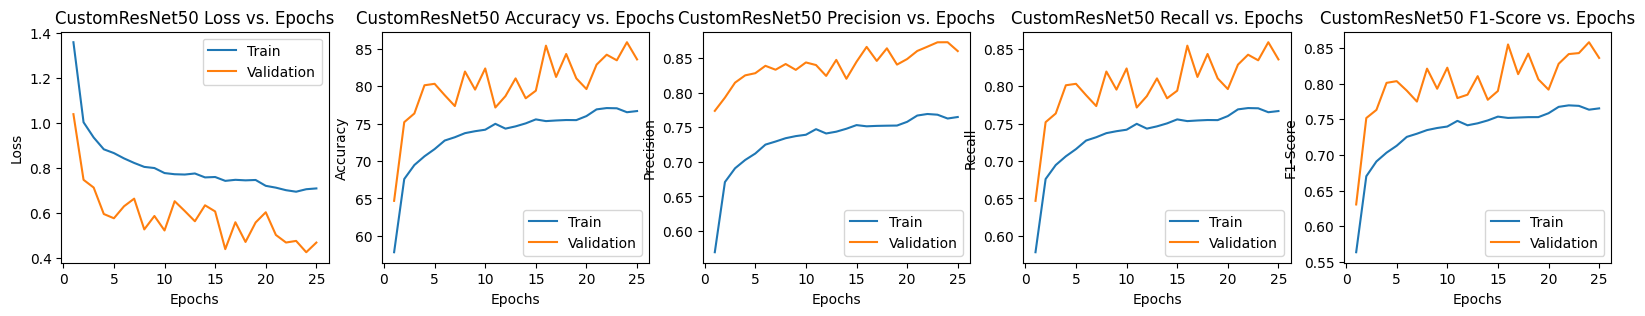

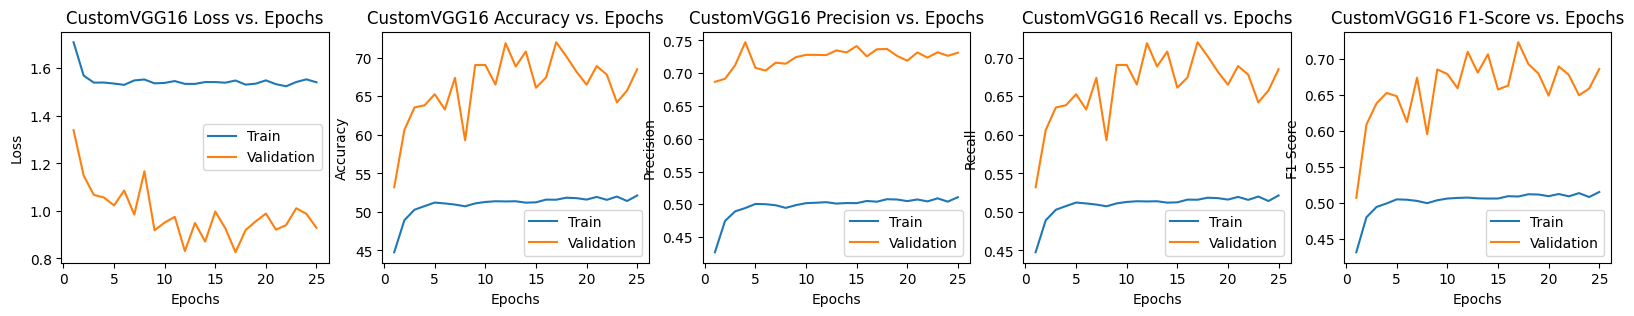

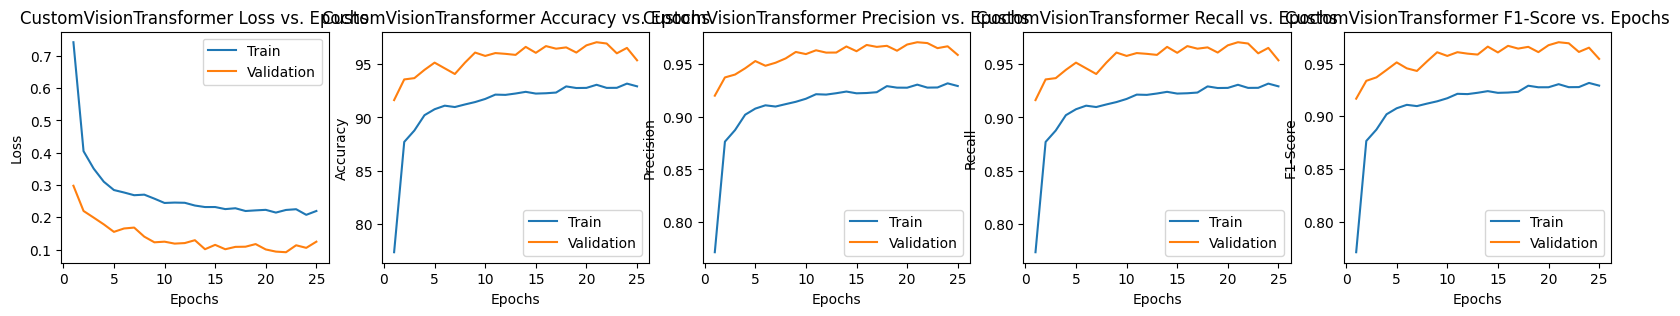

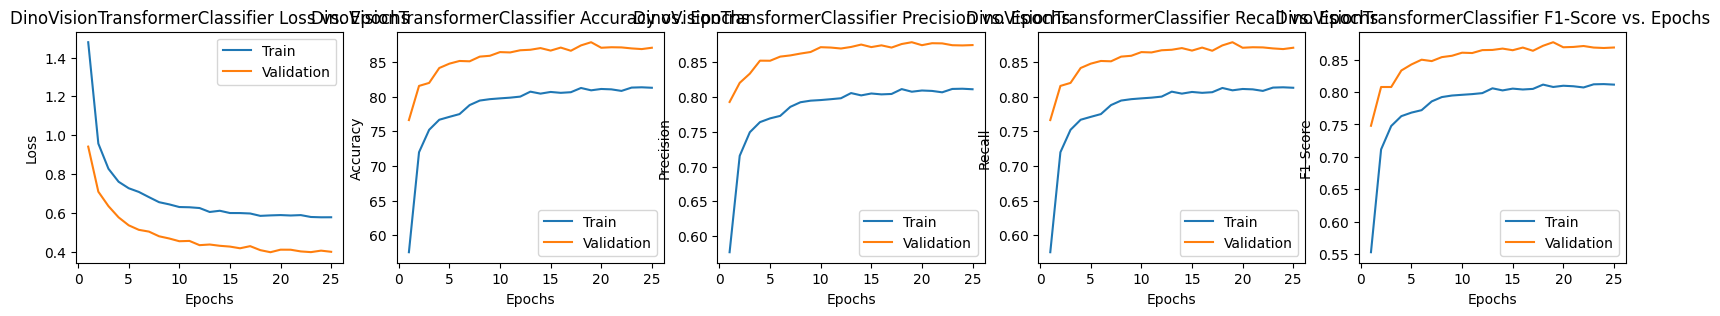

In [16]:
for model, train_losses, val_losses, train_acc, val_acc, train_pres, val_pres, train_recal, val_recal, train_f1, val_f1 in zip(models, training_loss, validation_loss, training_accuracy, validation_accuracy,training_precisions,validation_precisions,training_recalls,validation_recalls,training_f1_scores,validation_f1_scores):
    plt.figure(figsize=(20,3))
    plt.subplot(1, 5, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
    plt.title('{} Loss vs. Epochs'.format(type(model).__name__))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 5, 2)
    plt.plot(range(1, num_epochs + 1), train_acc, label='Train')
    plt.plot(range(1, num_epochs + 1), val_acc, label='Validation')
    plt.title('{} Accuracy vs. Epochs'.format(type(model).__name__))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 5, 3)
    plt.plot(range(1, num_epochs + 1), train_pres, label='Train')
    plt.plot(range(1, num_epochs + 1), val_pres, label='Validation')
    plt.title('{} Precision vs. Epochs'.format(type(model).__name__))
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    
    plt.subplot(1, 5, 4)
    plt.plot(range(1, num_epochs + 1), train_recal, label='Train')
    plt.plot(range(1, num_epochs + 1), val_recal, label='Validation')
    plt.title('{} Recall vs. Epochs'.format(type(model).__name__))
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    
    plt.subplot(1, 5, 5)
    plt.plot(range(1, num_epochs + 1), train_f1, label='Train')
    plt.plot(range(1, num_epochs + 1), val_f1, label='Validation')
    plt.title('{} F1-Score vs. Epochs'.format(type(model).__name__))
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()
    
    plt.show()

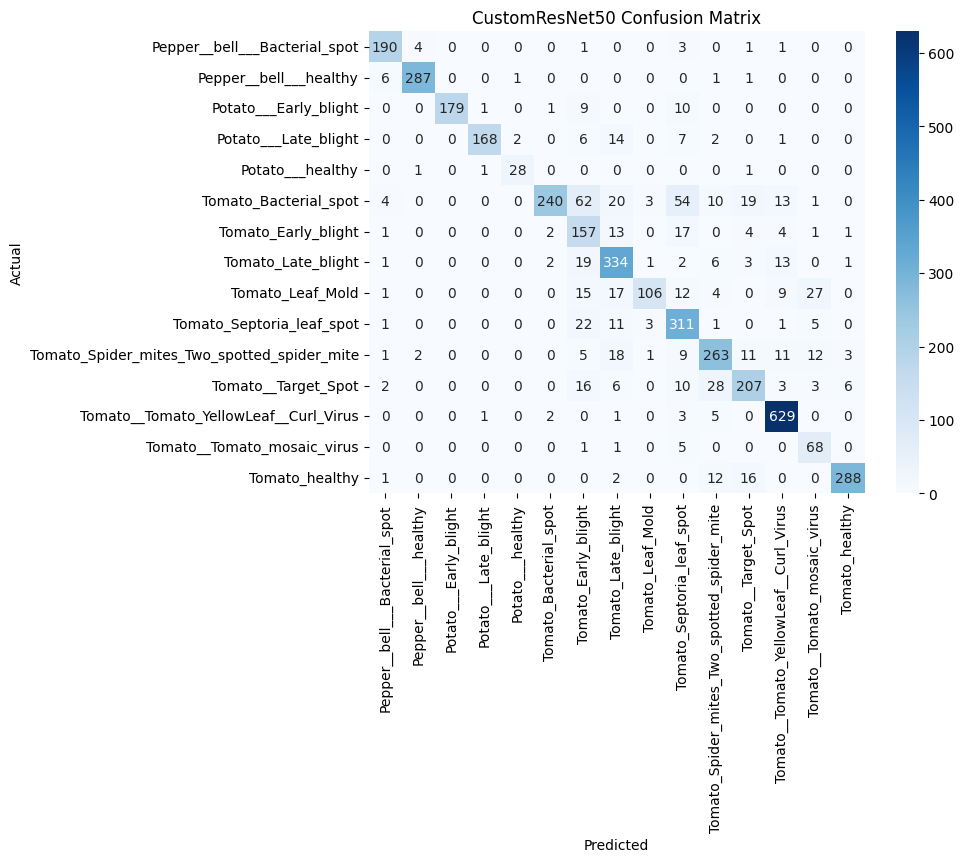

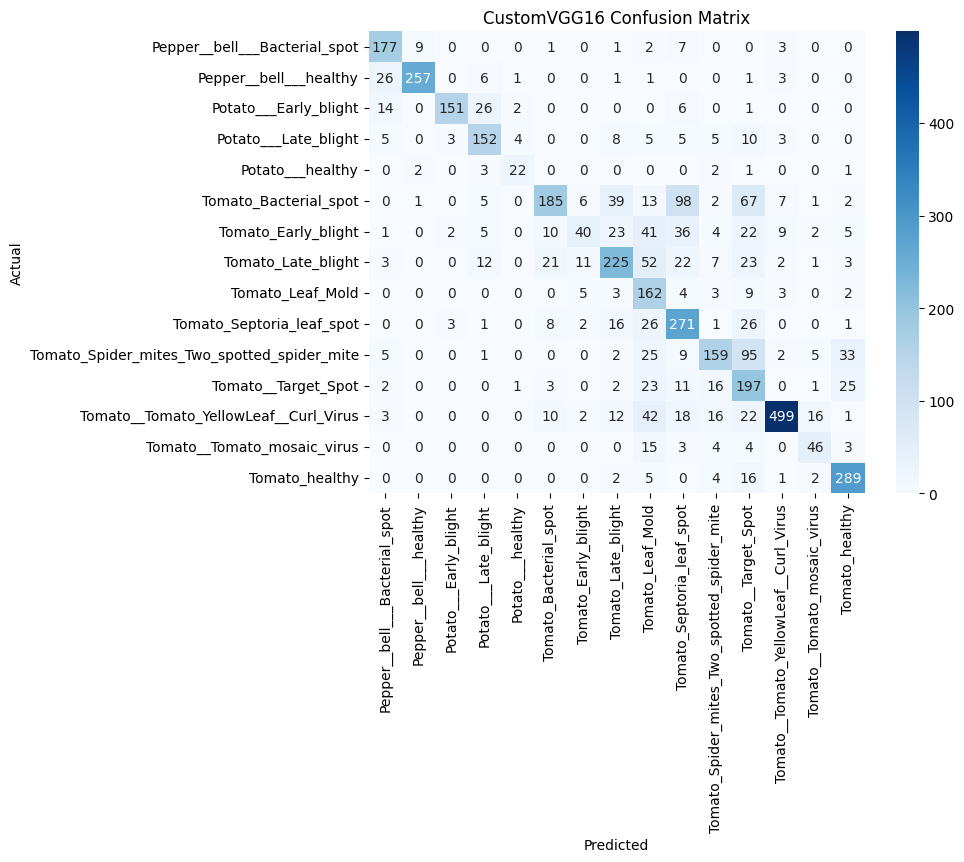

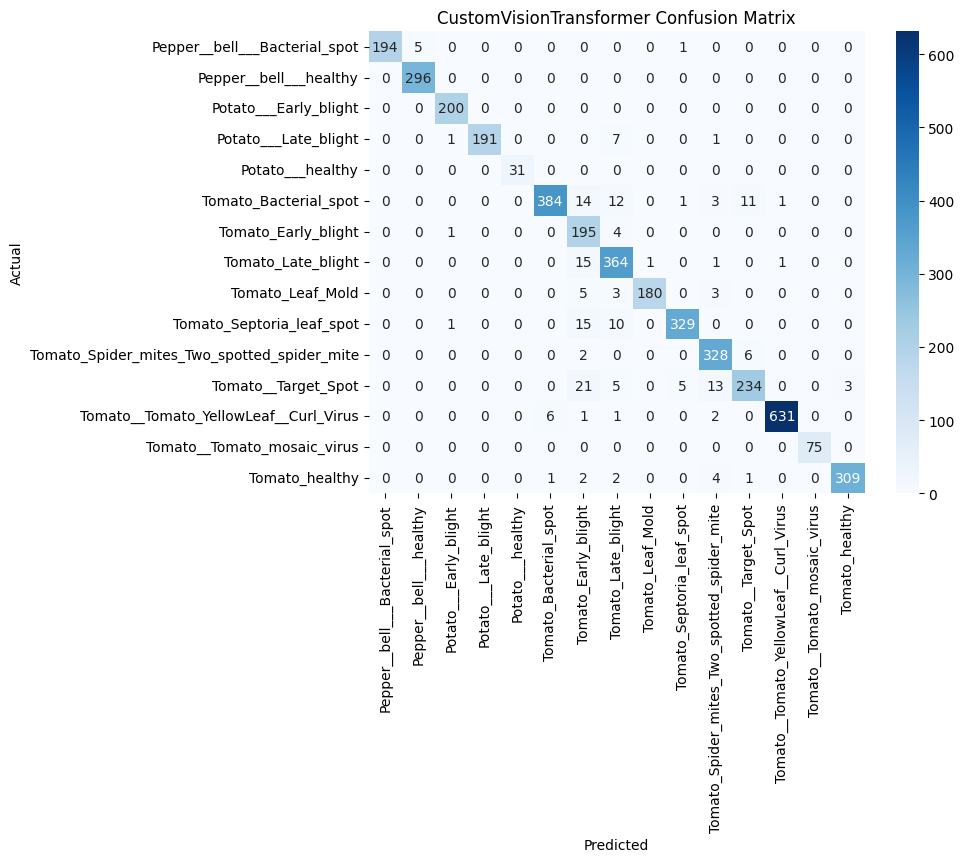

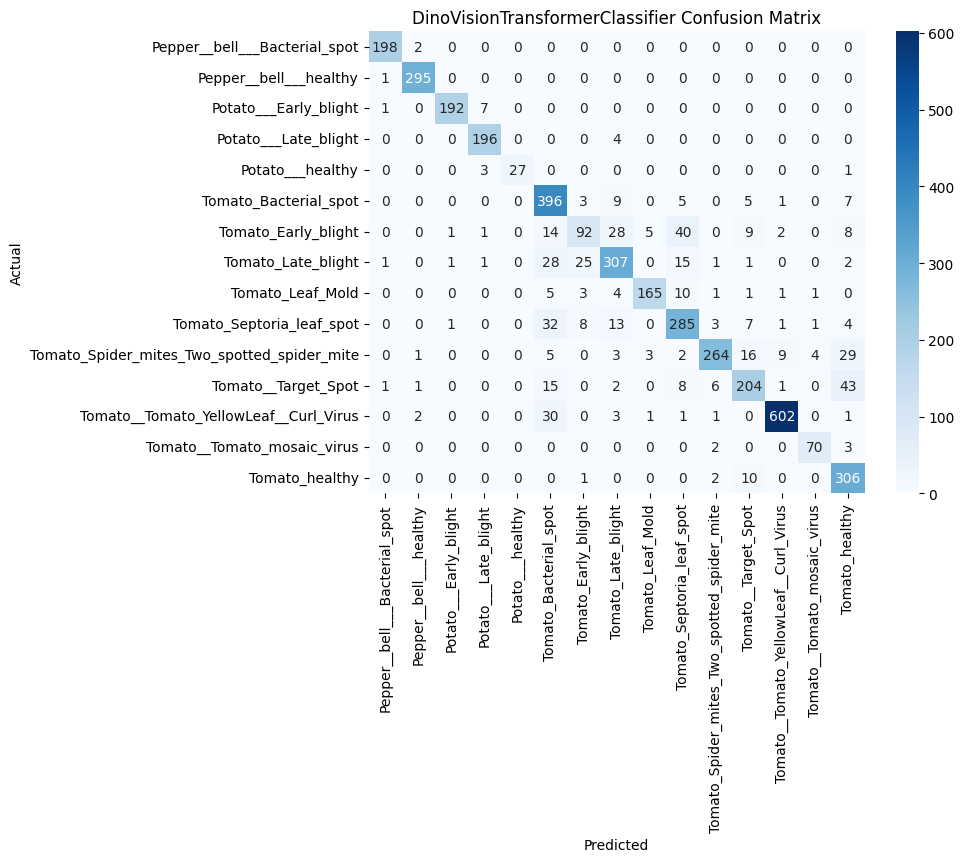

In [17]:
for model in models:
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('{} Confusion Matrix'.format(type(model).__name__))
    plt.show()

In [18]:
import torch

model_paths = {
    "resnet50": "model_resnet50.pth",
    "vgg16": "model_vgg16.pth",
    "vit": "model_vit.pth",
    "dino": "model_dino.pth"
}


torch.save(model_resnet50.state_dict(), model_paths["Resnet50"])
torch.save(model_vgg16.state_dict(), model_paths["Vgg16"])
torch.save(model_vit.state_dict(), model_paths["Vit"])
torch.save(model_dino.state_dict(), model_paths["Dino"])

torch.save(model_vit.state_dict(), '/content/model_vit.pth')


print("All models saved successfully!")

All models saved successfully!


In [ ]:

num_epochs = 25

for epoch in tqdm(range(num_epochs), total=num_epochs):
    for model, optimizer, train_losses, val_losses, train_acc, val_acc, train_precisions, val_precisions, train_recalls, val_recalls, train_f1_scores, val_f1_scores in zip(models, optimizers, training_loss, validation_loss, training_accuracy, validation_accuracy, training_precisions, validation_precisions, training_recalls, validation_recalls, training_f1_scores, validation_f1_scores):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        predictions = []
        true_labels = []

        for inputs, labels in (train_loader):
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

        train_losses.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        
        train_precision = precision_score(true_labels, predictions, average='weighted')
        train_rec = recall_score(true_labels, predictions, average='weighted')
        train_f1 = f1_score(true_labels, predictions, average='weighted')
        
        train_precisions.append(train_precision)
        train_recalls.append(train_rec)
        train_f1_scores.append(train_f1)

        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        predictions = []
        true_labels = []

        with torch.no_grad():
            for inputs, labels in (val_loader):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        val_losses.append(running_loss / len(val_loader))
        val_acc.append(100 * correct / total)

        val_precision = precision_score(true_labels, predictions, average='weighted')
        val_rec = recall_score(true_labels, predictions, average='weighted')
        val_f1 = f1_score(true_labels, predictions, average='weighted')

        val_precisions.append(val_precision)
        val_recalls.append(val_rec)
        val_f1_scores.append(val_f1)
        
        print(f"Model: {type(model).__name__}, Epoch: {epoch + 1}")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_acc[-1]:.2f}%")
        print(f"Train Precision: {train_precision:.4f}, Train Recall: {train_rec:.4f}, Train F1 Score: {train_f1:.4f}")
        print(f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_acc[-1]:.2f}%")
        print(f"Validation Precision: {val_precision:.4f}, Validation Recall: {val_rec:.4f}, Validation F1 Score: {val_f1:.4f}")
        print('\n')

In [16]:
models = [model_resnet50, model_vgg16,  model_vit, model_dino, model_hybrid]

In [17]:
num_epochs = 25
early_stopping_patience = 5  # Number of epochs to wait for improvement
best_accuracy = [0] * len(models)  # Best accuracy for each model
epochs_without_improvement = [0] * len(models)  # Counter for epochs without improvement

for epoch in tqdm(range(num_epochs), total=num_epochs):
    for i, (model, optimizer, train_losses, val_losses, train_acc, val_acc, train_precisions, val_precisions, train_recalls, val_recalls, train_f1_scores, val_f1_scores) in enumerate(zip(models, optimizers, training_loss, validation_loss, training_accuracy, validation_accuracy, training_precisions, validation_precisions, training_recalls, validation_recalls, training_f1_scores, validation_f1_scores)):
        
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        predictions = []
        true_labels = []

        # Training Loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

        train_losses.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        train_precision = precision_score(true_labels, predictions, average='weighted')
        train_rec = recall_score(true_labels, predictions, average='weighted')
        train_f1 = f1_score(true_labels, predictions, average='weighted')
        
        train_precisions.append(train_precision)
        train_recalls.append(train_rec)
        train_f1_scores.append(train_f1)

        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        predictions = []
        true_labels = []

        # Validation Loop
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

        val_losses.append(running_loss / len(val_loader))
        val_acc.append(100 * correct / total)

        val_precision = precision_score(true_labels, predictions, average='weighted')
        val_rec = recall_score(true_labels, predictions, average='weighted')
        val_f1 = f1_score(true_labels, predictions, average='weighted')

        val_precisions.append(val_precision)
        val_recalls.append(val_rec)
        val_f1_scores.append(val_f1)

        print(f"Model: {type(model).__name__}, Epoch: {epoch + 1}")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_acc[-1]:.2f}%")
        print(f"Train Precision: {train_precision:.4f}, Train Recall: {train_rec:.4f}, Train F1 Score: {train_f1:.4f}")
        print(f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_acc[-1]:.2f}%")
        print(f"Validation Precision: {val_precision:.4f}, Validation Recall: {val_rec:.4f}, Validation F1 Score: {val_f1:.4f}")
        print('\n')

        # Early Stopping
        if val_acc[-1] > best_accuracy[i]:  
            best_accuracy[i] = val_acc[-1]  
            epochs_without_improvement[i] = 0  
            
        else:
            epochs_without_improvement[i] += 1 

        
        if epochs_without_improvement[i] >= early_stopping_patience:
            torch.save(model.state_dict(), f"{type(model).__name__}_best_model.pth")
            print(f"Stopping training for model {type(model).__name__} due to early stopping.")
            break

  0%|          | 0/25 [00:00<?, ?it/s]

Model: CustomResNet50, Epoch: 1
Train Loss: 1.3784, Train Accuracy: 57.25%
Train Precision: 0.5666, Train Recall: 0.5725, Train F1 Score: 0.5594
Validation Loss: 0.9684, Validation Accuracy: 66.88%
Validation Precision: 0.7717, Validation Recall: 0.6688, Validation F1 Score: 0.6595


Model: CustomVGG16, Epoch: 1
Train Loss: 1.7050, Train Accuracy: 44.84%
Train Precision: 0.4277, Train Recall: 0.4484, Train F1 Score: 0.4319
Validation Loss: 1.2505, Validation Accuracy: 57.23%
Validation Precision: 0.6515, Validation Recall: 0.5723, Validation F1 Score: 0.5744


Model: CustomVisionTransformer, Epoch: 1
Train Loss: 0.7352, Train Accuracy: 77.75%
Train Precision: 0.7749, Train Recall: 0.7775, Train F1 Score: 0.7745
Validation Loss: 0.2992, Validation Accuracy: 91.70%
Validation Precision: 0.9239, Validation Recall: 0.9170, Validation F1 Score: 0.9181


Model: DinoVisionTransformerClassifier, Epoch: 1
Train Loss: 1.5183, Train Accuracy: 55.86%
Train Precision: 0.5654, Train Recall: 0.5586, 

  4%|▍         | 1/25 [24:10<9:40:08, 1450.34s/it]

Model: HybridCNNViTClassifier, Epoch: 1
Train Loss: 2.5851, Train Accuracy: 14.73%
Train Precision: 0.0933, Train Recall: 0.1473, Train F1 Score: 0.0728
Validation Loss: 2.5735, Validation Accuracy: 15.53%
Validation Precision: 0.0241, Validation Recall: 0.1553, Validation F1 Score: 0.0418


Model: CustomResNet50, Epoch: 2
Train Loss: 1.0071, Train Accuracy: 67.57%
Train Precision: 0.6702, Train Recall: 0.6757, Train F1 Score: 0.6706
Validation Loss: 0.7860, Validation Accuracy: 73.10%
Validation Precision: 0.8052, Validation Recall: 0.7310, Validation F1 Score: 0.7293


Model: CustomVGG16, Epoch: 2
Train Loss: 1.5701, Train Accuracy: 49.18%
Train Precision: 0.4773, Train Recall: 0.4918, Train F1 Score: 0.4821
Validation Loss: 1.1756, Validation Accuracy: 59.19%
Validation Precision: 0.6698, Validation Recall: 0.5919, Validation F1 Score: 0.5870


Model: CustomVisionTransformer, Epoch: 2
Train Loss: 0.4076, Train Accuracy: 87.26%
Train Precision: 0.8716, Train Recall: 0.8726, Train F1 

  8%|▊         | 2/25 [48:14<9:14:31, 1446.59s/it]

Model: HybridCNNViTClassifier, Epoch: 2
Train Loss: 2.5549, Train Accuracy: 15.36%
Train Precision: 0.0646, Train Recall: 0.1536, Train F1 Score: 0.0541
Validation Loss: 2.5798, Validation Accuracy: 15.53%
Validation Precision: 0.0241, Validation Recall: 0.1553, Validation F1 Score: 0.0418


Model: CustomResNet50, Epoch: 3
Train Loss: 0.9263, Train Accuracy: 69.58%
Train Precision: 0.6918, Train Recall: 0.6958, Train F1 Score: 0.6920
Validation Loss: 0.7962, Validation Accuracy: 71.58%
Validation Precision: 0.8055, Validation Recall: 0.7158, Validation F1 Score: 0.7143


Model: CustomVGG16, Epoch: 3
Train Loss: 1.5395, Train Accuracy: 50.52%
Train Precision: 0.4910, Train Recall: 0.5052, Train F1 Score: 0.4962
Validation Loss: 1.1194, Validation Accuracy: 61.37%
Validation Precision: 0.6961, Validation Recall: 0.6137, Validation F1 Score: 0.6046


Model: CustomVisionTransformer, Epoch: 3
Train Loss: 0.3421, Train Accuracy: 89.08%
Train Precision: 0.8903, Train Recall: 0.8908, Train F1 

 12%|█▏        | 3/25 [1:12:17<8:49:53, 1445.14s/it]

Model: HybridCNNViTClassifier, Epoch: 3
Train Loss: 2.5401, Train Accuracy: 15.58%
Train Precision: 0.0869, Train Recall: 0.1558, Train F1 Score: 0.0655
Validation Loss: 2.5769, Validation Accuracy: 14.93%
Validation Precision: 0.0342, Validation Recall: 0.1493, Validation F1 Score: 0.0457


Model: CustomResNet50, Epoch: 4
Train Loss: 0.8837, Train Accuracy: 71.26%
Train Precision: 0.7088, Train Recall: 0.7126, Train F1 Score: 0.7093
Validation Loss: 0.7068, Validation Accuracy: 75.52%
Validation Precision: 0.8282, Validation Recall: 0.7552, Validation F1 Score: 0.7594


Model: CustomVGG16, Epoch: 4
Train Loss: 1.5352, Train Accuracy: 50.60%
Train Precision: 0.4931, Train Recall: 0.5060, Train F1 Score: 0.4979
Validation Loss: 1.2456, Validation Accuracy: 57.18%
Validation Precision: 0.6825, Validation Recall: 0.5718, Validation F1 Score: 0.5746


Model: CustomVisionTransformer, Epoch: 4
Train Loss: 0.3156, Train Accuracy: 89.77%
Train Precision: 0.8973, Train Recall: 0.8977, Train F1 

 16%|█▌        | 4/25 [1:36:21<8:25:37, 1444.66s/it]

Model: HybridCNNViTClassifier, Epoch: 4
Train Loss: 2.5395, Train Accuracy: 15.56%
Train Precision: 0.1133, Train Recall: 0.1556, Train F1 Score: 0.0722
Validation Loss: 2.5751, Validation Accuracy: 14.78%
Validation Precision: 0.0447, Validation Recall: 0.1478, Validation F1 Score: 0.0463


Model: CustomResNet50, Epoch: 5
Train Loss: 0.8581, Train Accuracy: 71.95%
Train Precision: 0.7158, Train Recall: 0.7195, Train F1 Score: 0.7166
Validation Loss: 0.7186, Validation Accuracy: 74.53%
Validation Precision: 0.8274, Validation Recall: 0.7453, Validation F1 Score: 0.7537


Model: CustomVGG16, Epoch: 5
Train Loss: 1.5504, Train Accuracy: 50.58%
Train Precision: 0.4945, Train Recall: 0.5058, Train F1 Score: 0.4985
Validation Loss: 0.9986, Validation Accuracy: 67.27%
Validation Precision: 0.7118, Validation Recall: 0.6727, Validation F1 Score: 0.6756


Model: CustomVisionTransformer, Epoch: 5
Train Loss: 0.2890, Train Accuracy: 90.60%
Train Precision: 0.9057, Train Recall: 0.9060, Train F1 

 20%|██        | 5/25 [2:00:21<8:01:02, 1443.10s/it]

Model: HybridCNNViTClassifier, Epoch: 5
Train Loss: 2.5333, Train Accuracy: 16.03%
Train Precision: 0.0881, Train Recall: 0.1603, Train F1 Score: 0.0755
Validation Loss: 2.6077, Validation Accuracy: 14.47%
Validation Precision: 0.0459, Validation Recall: 0.1447, Validation F1 Score: 0.0604


Model: CustomResNet50, Epoch: 6
Train Loss: 0.8509, Train Accuracy: 72.11%
Train Precision: 0.7180, Train Recall: 0.7211, Train F1 Score: 0.7188
Validation Loss: 0.8275, Validation Accuracy: 72.28%
Validation Precision: 0.8065, Validation Recall: 0.7228, Validation F1 Score: 0.7130


Model: CustomVGG16, Epoch: 6
Train Loss: 1.5303, Train Accuracy: 51.10%
Train Precision: 0.4987, Train Recall: 0.5110, Train F1 Score: 0.5033
Validation Loss: 1.0325, Validation Accuracy: 64.27%
Validation Precision: 0.6990, Validation Recall: 0.6427, Validation F1 Score: 0.6431


Model: CustomVisionTransformer, Epoch: 6
Train Loss: 0.2822, Train Accuracy: 90.80%
Train Precision: 0.9075, Train Recall: 0.9080, Train F1 

 24%|██▍       | 6/25 [2:24:19<7:36:19, 1441.05s/it]

Model: HybridCNNViTClassifier, Epoch: 6
Train Loss: 2.5292, Train Accuracy: 16.03%
Train Precision: 0.1183, Train Recall: 0.1603, Train F1 Score: 0.0778
Validation Loss: 2.5703, Validation Accuracy: 15.89%
Validation Precision: 0.0656, Validation Recall: 0.1589, Validation F1 Score: 0.0626


Model: CustomResNet50, Epoch: 7
Train Loss: 0.8224, Train Accuracy: 73.05%
Train Precision: 0.7271, Train Recall: 0.7305, Train F1 Score: 0.7282
Validation Loss: 0.5871, Validation Accuracy: 79.46%
Validation Precision: 0.8246, Validation Recall: 0.7946, Validation F1 Score: 0.7912


Model: CustomVGG16, Epoch: 7
Train Loss: 1.5463, Train Accuracy: 50.84%
Train Precision: 0.4981, Train Recall: 0.5084, Train F1 Score: 0.5020
Validation Loss: 1.2216, Validation Accuracy: 59.12%
Validation Precision: 0.6953, Validation Recall: 0.5912, Validation F1 Score: 0.5973


Model: CustomVisionTransformer, Epoch: 7
Train Loss: 0.2639, Train Accuracy: 91.23%
Train Precision: 0.9120, Train Recall: 0.9123, Train F1 

 28%|██▊       | 7/25 [2:48:15<7:11:49, 1439.43s/it]

Model: HybridCNNViTClassifier, Epoch: 7
Train Loss: 2.5264, Train Accuracy: 16.07%
Train Precision: 0.0727, Train Recall: 0.1607, Train F1 Score: 0.0764
Validation Loss: 2.5600, Validation Accuracy: 16.30%
Validation Precision: 0.0648, Validation Recall: 0.1630, Validation F1 Score: 0.0678


Model: CustomResNet50, Epoch: 8
Train Loss: 0.8036, Train Accuracy: 73.55%
Train Precision: 0.7330, Train Recall: 0.7355, Train F1 Score: 0.7336
Validation Loss: 0.5181, Validation Accuracy: 82.20%
Validation Precision: 0.8507, Validation Recall: 0.8220, Validation F1 Score: 0.8251


Model: CustomVGG16, Epoch: 8
Train Loss: 1.5444, Train Accuracy: 50.96%
Train Precision: 0.4984, Train Recall: 0.5096, Train F1 Score: 0.5025
Validation Loss: 0.9975, Validation Accuracy: 66.16%
Validation Precision: 0.7065, Validation Recall: 0.6616, Validation F1 Score: 0.6592


Model: CustomVisionTransformer, Epoch: 8
Train Loss: 0.2501, Train Accuracy: 91.86%
Train Precision: 0.9184, Train Recall: 0.9186, Train F1 

 32%|███▏      | 8/25 [3:12:09<6:47:20, 1437.67s/it]

Model: HybridCNNViTClassifier, Epoch: 8
Train Loss: 2.5230, Train Accuracy: 16.32%
Train Precision: 0.1028, Train Recall: 0.1632, Train F1 Score: 0.0798
Validation Loss: 2.5508, Validation Accuracy: 15.58%
Validation Precision: 0.0363, Validation Recall: 0.1558, Validation F1 Score: 0.0428


Model: CustomResNet50, Epoch: 9
Train Loss: 0.8018, Train Accuracy: 73.45%
Train Precision: 0.7311, Train Recall: 0.7345, Train F1 Score: 0.7321
Validation Loss: 0.6241, Validation Accuracy: 78.96%
Validation Precision: 0.8419, Validation Recall: 0.7896, Validation F1 Score: 0.7928


Model: CustomVGG16, Epoch: 9
Train Loss: 1.5400, Train Accuracy: 51.24%
Train Precision: 0.5004, Train Recall: 0.5124, Train F1 Score: 0.5052
Validation Loss: 0.9949, Validation Accuracy: 65.67%
Validation Precision: 0.7137, Validation Recall: 0.6567, Validation F1 Score: 0.6603


Model: CustomVisionTransformer, Epoch: 9
Train Loss: 0.2530, Train Accuracy: 91.92%
Train Precision: 0.9190, Train Recall: 0.9192, Train F1 

 36%|███▌      | 9/25 [3:36:02<6:23:02, 1436.41s/it]

Model: HybridCNNViTClassifier, Epoch: 9
Train Loss: 2.5239, Train Accuracy: 16.29%
Train Precision: 0.0637, Train Recall: 0.1629, Train F1 Score: 0.0756
Validation Loss: 2.5604, Validation Accuracy: 15.77%
Validation Precision: 0.0571, Validation Recall: 0.1577, Validation F1 Score: 0.0657


Model: CustomResNet50, Epoch: 10
Train Loss: 0.8108, Train Accuracy: 73.23%
Train Precision: 0.7295, Train Recall: 0.7323, Train F1 Score: 0.7302
Validation Loss: 0.6468, Validation Accuracy: 77.58%
Validation Precision: 0.8260, Validation Recall: 0.7758, Validation F1 Score: 0.7748


Model: CustomVGG16, Epoch: 10
Train Loss: 1.5479, Train Accuracy: 50.82%
Train Precision: 0.4962, Train Recall: 0.5082, Train F1 Score: 0.5007
Validation Loss: 0.9700, Validation Accuracy: 67.10%
Validation Precision: 0.7211, Validation Recall: 0.6710, Validation F1 Score: 0.6629




 40%|████      | 10/25 [3:41:49<4:34:58, 1099.89s/it]

Stopping training for model CustomVGG16 due to early stopping.
Model: CustomResNet50, Epoch: 11
Train Loss: 0.7855, Train Accuracy: 73.93%
Train Precision: 0.7367, Train Recall: 0.7393, Train F1 Score: 0.7373
Validation Loss: 0.5472, Validation Accuracy: 80.91%
Validation Precision: 0.8496, Validation Recall: 0.8091, Validation F1 Score: 0.8124


Model: CustomVGG16, Epoch: 11
Train Loss: 1.5543, Train Accuracy: 51.38%
Train Precision: 0.5016, Train Recall: 0.5138, Train F1 Score: 0.5064
Validation Loss: 0.9913, Validation Accuracy: 65.80%
Validation Precision: 0.7043, Validation Recall: 0.6580, Validation F1 Score: 0.6510




 44%|████▍     | 11/25 [3:47:38<3:23:02, 870.15s/it] 

Stopping training for model CustomVGG16 due to early stopping.
Model: CustomResNet50, Epoch: 12
Train Loss: 0.7761, Train Accuracy: 74.19%
Train Precision: 0.7395, Train Recall: 0.7419, Train F1 Score: 0.7402
Validation Loss: 0.5606, Validation Accuracy: 80.79%
Validation Precision: 0.8384, Validation Recall: 0.8079, Validation F1 Score: 0.8089


Model: CustomVGG16, Epoch: 12
Train Loss: 1.5419, Train Accuracy: 51.30%
Train Precision: 0.5033, Train Recall: 0.5130, Train F1 Score: 0.5071
Validation Loss: 1.0019, Validation Accuracy: 66.26%
Validation Precision: 0.7159, Validation Recall: 0.6626, Validation F1 Score: 0.6690




 48%|████▊     | 12/25 [3:53:25<2:34:02, 710.93s/it]

Stopping training for model CustomVGG16 due to early stopping.


 52%|█████▏    | 13/25 [3:56:10<1:49:07, 545.63s/it]

Model: CustomResNet50, Epoch: 13
Train Loss: 0.7397, Train Accuracy: 75.65%
Train Precision: 0.7540, Train Recall: 0.7565, Train F1 Score: 0.7547
Validation Loss: 0.6075, Validation Accuracy: 78.88%
Validation Precision: 0.8445, Validation Recall: 0.7888, Validation F1 Score: 0.7865


Stopping training for model CustomResNet50 due to early stopping.
Model: CustomResNet50, Epoch: 14
Train Loss: 0.7584, Train Accuracy: 74.78%
Train Precision: 0.7457, Train Recall: 0.7478, Train F1 Score: 0.7464
Validation Loss: 0.6007, Validation Accuracy: 79.29%
Validation Precision: 0.8477, Validation Recall: 0.7929, Validation F1 Score: 0.7967




 56%|█████▌    | 14/25 [3:58:55<1:18:57, 430.72s/it]

Stopping training for model CustomResNet50 due to early stopping.
Model: CustomResNet50, Epoch: 15
Train Loss: 0.7377, Train Accuracy: 75.61%
Train Precision: 0.7537, Train Recall: 0.7561, Train F1 Score: 0.7544
Validation Loss: 0.6211, Validation Accuracy: 78.42%
Validation Precision: 0.8318, Validation Recall: 0.7842, Validation F1 Score: 0.7814




 60%|██████    | 15/25 [4:01:40<58:25, 350.53s/it]  

Stopping training for model CustomResNet50 due to early stopping.
Model: CustomResNet50, Epoch: 16
Train Loss: 0.7429, Train Accuracy: 75.44%
Train Precision: 0.7522, Train Recall: 0.7544, Train F1 Score: 0.7528
Validation Loss: 0.5316, Validation Accuracy: 81.28%
Validation Precision: 0.8497, Validation Recall: 0.8128, Validation F1 Score: 0.8112




 64%|██████▍   | 16/25 [4:04:25<44:12, 294.71s/it]

Stopping training for model CustomResNet50 due to early stopping.
Model: CustomResNet50, Epoch: 17
Train Loss: 0.7432, Train Accuracy: 75.41%
Train Precision: 0.7518, Train Recall: 0.7541, Train F1 Score: 0.7525
Validation Loss: 0.4678, Validation Accuracy: 83.62%
Validation Precision: 0.8617, Validation Recall: 0.8362, Validation F1 Score: 0.8397


Model: CustomVGG16, Epoch: 17
Train Loss: 1.5367, Train Accuracy: 51.08%
Train Precision: 0.4985, Train Recall: 0.5108, Train F1 Score: 0.5034
Validation Loss: 1.1007, Validation Accuracy: 63.69%
Validation Precision: 0.7160, Validation Recall: 0.6369, Validation F1 Score: 0.6413




 68%|██████▊   | 17/25 [4:10:12<41:24, 310.60s/it]

Stopping training for model CustomVGG16 due to early stopping.
Model: CustomResNet50, Epoch: 18
Train Loss: 0.7265, Train Accuracy: 76.44%
Train Precision: 0.7617, Train Recall: 0.7644, Train F1 Score: 0.7625
Validation Loss: 0.6036, Validation Accuracy: 79.68%
Validation Precision: 0.8448, Validation Recall: 0.7968, Validation F1 Score: 0.7984


Model: CustomVGG16, Epoch: 18
Train Loss: 1.5437, Train Accuracy: 51.84%
Train Precision: 0.5074, Train Recall: 0.5184, Train F1 Score: 0.5116
Validation Loss: 0.8919, Validation Accuracy: 69.76%
Validation Precision: 0.7151, Validation Recall: 0.6976, Validation F1 Score: 0.6982


Model: CustomVisionTransformer, Epoch: 18
Train Loss: 0.2546, Train Accuracy: 91.87%
Train Precision: 0.9184, Train Recall: 0.9187, Train F1 Score: 0.9185
Validation Loss: 0.1245, Validation Accuracy: 95.94%
Validation Precision: 0.9604, Validation Recall: 0.9594, Validation F1 Score: 0.9594


Model: DinoVisionTransformerClassifier, Epoch: 18
Train Loss: 0.6525, Tra

 72%|███████▏  | 18/25 [4:34:09<1:15:43, 649.10s/it]

Model: HybridCNNViTClassifier, Epoch: 18
Train Loss: 2.5197, Train Accuracy: 16.26%
Train Precision: 0.0700, Train Recall: 0.1626, Train F1 Score: 0.0796
Validation Loss: 2.5378, Validation Accuracy: 15.60%
Validation Precision: 0.0429, Validation Recall: 0.1560, Validation F1 Score: 0.0438


Model: CustomResNet50, Epoch: 19
Train Loss: 0.7280, Train Accuracy: 75.71%
Train Precision: 0.7546, Train Recall: 0.7571, Train F1 Score: 0.7553
Validation Loss: 0.6035, Validation Accuracy: 79.66%
Validation Precision: 0.8416, Validation Recall: 0.7966, Validation F1 Score: 0.7923


Model: CustomVGG16, Epoch: 19
Train Loss: 1.5479, Train Accuracy: 51.54%
Train Precision: 0.5045, Train Recall: 0.5154, Train F1 Score: 0.5086
Validation Loss: 0.9296, Validation Accuracy: 68.48%
Validation Precision: 0.7190, Validation Recall: 0.6848, Validation F1 Score: 0.6911


Model: CustomVisionTransformer, Epoch: 19
Train Loss: 0.2450, Train Accuracy: 91.98%
Train Precision: 0.9195, Train Recall: 0.9198, Train

 76%|███████▌  | 19/25 [4:58:08<1:28:37, 886.21s/it]

Model: HybridCNNViTClassifier, Epoch: 19
Train Loss: 2.5121, Train Accuracy: 16.60%
Train Precision: 0.0845, Train Recall: 0.1660, Train F1 Score: 0.0843
Validation Loss: 2.5337, Validation Accuracy: 15.53%
Validation Precision: 0.0596, Validation Recall: 0.1553, Validation F1 Score: 0.0460


Model: CustomResNet50, Epoch: 20
Train Loss: 0.7416, Train Accuracy: 75.54%
Train Precision: 0.7535, Train Recall: 0.7554, Train F1 Score: 0.7539
Validation Loss: 0.4949, Validation Accuracy: 83.14%
Validation Precision: 0.8618, Validation Recall: 0.8314, Validation F1 Score: 0.8349


Model: CustomVGG16, Epoch: 20
Train Loss: 1.5283, Train Accuracy: 51.87%
Train Precision: 0.5076, Train Recall: 0.5187, Train F1 Score: 0.5117
Validation Loss: 0.9013, Validation Accuracy: 69.86%
Validation Precision: 0.7250, Validation Recall: 0.6986, Validation F1 Score: 0.6994


Model: CustomVisionTransformer, Epoch: 20
Train Loss: 0.2334, Train Accuracy: 92.35%
Train Precision: 0.9233, Train Recall: 0.9235, Train

 80%|████████  | 20/25 [5:22:05<1:27:37, 1051.45s/it]

Model: HybridCNNViTClassifier, Epoch: 20
Train Loss: 2.5096, Train Accuracy: 16.65%
Train Precision: 0.0820, Train Recall: 0.1665, Train F1 Score: 0.0848
Validation Loss: 2.5500, Validation Accuracy: 16.64%
Validation Precision: 0.0831, Validation Recall: 0.1664, Validation F1 Score: 0.0729


Model: CustomResNet50, Epoch: 21
Train Loss: 0.7232, Train Accuracy: 76.21%
Train Precision: 0.7605, Train Recall: 0.7621, Train F1 Score: 0.7609
Validation Loss: 0.5038, Validation Accuracy: 82.41%
Validation Precision: 0.8547, Validation Recall: 0.8241, Validation F1 Score: 0.8242


Model: CustomVGG16, Epoch: 21
Train Loss: 1.5523, Train Accuracy: 51.41%
Train Precision: 0.5035, Train Recall: 0.5141, Train F1 Score: 0.5077
Validation Loss: 0.9622, Validation Accuracy: 67.80%
Validation Precision: 0.7367, Validation Recall: 0.6780, Validation F1 Score: 0.6815


Model: CustomVisionTransformer, Epoch: 21
Train Loss: 0.2278, Train Accuracy: 92.56%
Train Precision: 0.9253, Train Recall: 0.9256, Train

 84%|████████▍ | 21/25 [5:45:58<1:17:43, 1165.96s/it]

Model: HybridCNNViTClassifier, Epoch: 21
Train Loss: 2.5085, Train Accuracy: 16.80%
Train Precision: 0.0701, Train Recall: 0.1680, Train F1 Score: 0.0844
Validation Loss: 2.5452, Validation Accuracy: 15.77%
Validation Precision: 0.0641, Validation Recall: 0.1577, Validation F1 Score: 0.0745




 88%|████████▊ | 22/25 [5:48:43<43:17, 865.79s/it]   

Model: CustomResNet50, Epoch: 22
Train Loss: 0.7001, Train Accuracy: 77.21%
Train Precision: 0.7701, Train Recall: 0.7721, Train F1 Score: 0.7706
Validation Loss: 0.5035, Validation Accuracy: 82.90%
Validation Precision: 0.8672, Validation Recall: 0.8290, Validation F1 Score: 0.8324


Stopping training for model CustomResNet50 due to early stopping.
Model: CustomResNet50, Epoch: 23
Train Loss: 0.7106, Train Accuracy: 77.02%
Train Precision: 0.7679, Train Recall: 0.7702, Train F1 Score: 0.7686
Validation Loss: 0.4511, Validation Accuracy: 84.88%
Validation Precision: 0.8704, Validation Recall: 0.8488, Validation F1 Score: 0.8510


Model: CustomVGG16, Epoch: 23
Train Loss: 1.5404, Train Accuracy: 51.46%
Train Precision: 0.5040, Train Recall: 0.5146, Train F1 Score: 0.5083
Validation Loss: 0.8631, Validation Accuracy: 71.29%
Validation Precision: 0.7214, Validation Recall: 0.7129, Validation F1 Score: 0.7124


Model: CustomVisionTransformer, Epoch: 23
Train Loss: 0.2247, Train Accuracy: 9

 92%|█████████▏| 23/25 [6:12:36<34:31, 1035.88s/it]

Model: HybridCNNViTClassifier, Epoch: 23
Train Loss: 2.5068, Train Accuracy: 16.84%
Train Precision: 0.0730, Train Recall: 0.1684, Train F1 Score: 0.0850
Validation Loss: 2.6011, Validation Accuracy: 14.32%
Validation Precision: 0.0563, Validation Recall: 0.1432, Validation F1 Score: 0.0599


Model: CustomResNet50, Epoch: 24
Train Loss: 0.7213, Train Accuracy: 76.73%
Train Precision: 0.7652, Train Recall: 0.7673, Train F1 Score: 0.7658
Validation Loss: 0.4982, Validation Accuracy: 82.34%
Validation Precision: 0.8611, Validation Recall: 0.8234, Validation F1 Score: 0.8280


Model: CustomVGG16, Epoch: 24
Train Loss: 1.5616, Train Accuracy: 51.14%
Train Precision: 0.5007, Train Recall: 0.5114, Train F1 Score: 0.5049
Validation Loss: 0.8935, Validation Accuracy: 69.67%
Validation Precision: 0.7228, Validation Recall: 0.6967, Validation F1 Score: 0.6918


Model: CustomVisionTransformer, Epoch: 24
Train Loss: 0.2322, Train Accuracy: 92.24%
Train Precision: 0.9221, Train Recall: 0.9224, Train

 96%|█████████▌| 24/25 [6:36:32<19:15, 1155.88s/it]

Model: HybridCNNViTClassifier, Epoch: 24
Train Loss: 2.5049, Train Accuracy: 16.46%
Train Precision: 0.0760, Train Recall: 0.1646, Train F1 Score: 0.0852
Validation Loss: 2.5368, Validation Accuracy: 15.19%
Validation Precision: 0.0568, Validation Recall: 0.1519, Validation F1 Score: 0.0712


Model: CustomResNet50, Epoch: 25
Train Loss: 0.7201, Train Accuracy: 76.61%
Train Precision: 0.7642, Train Recall: 0.7661, Train F1 Score: 0.7647
Validation Loss: 0.5335, Validation Accuracy: 81.76%
Validation Precision: 0.8492, Validation Recall: 0.8176, Validation F1 Score: 0.8173


Model: CustomVGG16, Epoch: 25
Train Loss: 1.5475, Train Accuracy: 51.53%
Train Precision: 0.5051, Train Recall: 0.5153, Train F1 Score: 0.5089
Validation Loss: 0.9360, Validation Accuracy: 67.39%
Validation Precision: 0.7212, Validation Recall: 0.6739, Validation F1 Score: 0.6745


Model: CustomVisionTransformer, Epoch: 25
Train Loss: 0.2297, Train Accuracy: 92.57%
Train Precision: 0.9255, Train Recall: 0.9257, Train

100%|██████████| 25/25 [7:00:30<00:00, 1009.20s/it]

Model: HybridCNNViTClassifier, Epoch: 25
Train Loss: 2.5004, Train Accuracy: 16.87%
Train Precision: 0.1088, Train Recall: 0.1687, Train F1 Score: 0.0884
Validation Loss: 2.5253, Validation Accuracy: 16.38%
Validation Precision: 0.0625, Validation Recall: 0.1638, Validation F1 Score: 0.0729


